# Optimal ridge penalty for real-world high-dimensional data can be zero or negative due to the implicit ridge regularization

https://arxiv.org/abs/1805.10939

In [6]:
# Load libraries and set up the notebook

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns
import matplotlib

def sns_styleset():
    sns.set_context('paper')
    sns.set_style('ticks')
    matplotlib.rcParams['figure.dpi']        = 125
    matplotlib.rcParams['axes.linewidth']    = .75
    matplotlib.rcParams['xtick.major.width'] = .75
    matplotlib.rcParams['ytick.major.width'] = .75
    matplotlib.rcParams['xtick.major.size']  = 3
    matplotlib.rcParams['ytick.major.size']  = 3
    matplotlib.rcParams['xtick.minor.size']  = 2
    matplotlib.rcParams['ytick.minor.size']  = 2
    matplotlib.rcParams['font.size']         = 7
    matplotlib.rcParams['axes.titlesize']    = 7
    matplotlib.rcParams['axes.labelsize']    = 7
    matplotlib.rcParams['legend.fontsize']   = 7
    matplotlib.rcParams['xtick.labelsize']   = 7
    matplotlib.rcParams['ytick.labelsize']   = 7
    
sns_styleset()

## `Liver.toxicity` case study

Run `getData.R` in R to get the `.txt` files with data.

X shape: (64, 3116)
Y shape: (64, 10)


<IPython.core.display.Javascript object>


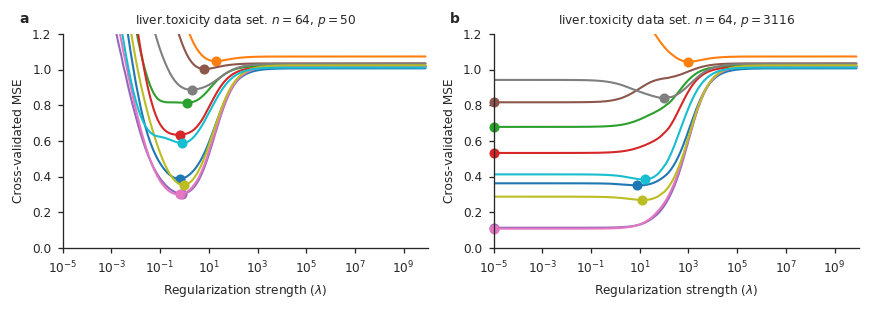

..........
..........
CPU times: user 46.6 s, sys: 416 ms, total: 47 s
Wall time: 19 s


In [7]:
%%time

# Using glmnet from https://web.stanford.edu/~hastie/glmnet_python/

import glmnet_python    
from cvglmnet import cvglmnet
from cvglmnetPlot import cvglmnetPlot

X = np.loadtxt('livertoxicity-gene.txt')
Y = np.loadtxt('livertoxicity-clinic.txt')
print('X shape:', X.shape)
print('Y shape:', Y.shape)

np.random.seed(42)
X = X[:, np.random.permutation(X.shape[1])]
X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)
Y = Y - np.mean(Y, axis=0)
Y = Y / np.std(Y, axis=0)

# Making this a function because we will run it again below
def makefigure1(X, Y):
    lambdau = np.array(10.0**np.arange(-5,10,.1))
    ps = [50, X.shape[1]]

    plt.figure(figsize=(7,2.5))

    for subplotnum, p in enumerate(ps):
        plt.subplot(1,2,subplotnum+1)
    
        for i in range(Y.shape[1]):
            print('.', end='')
            y = Y[:,i]
            fit = cvglmnet(x = X[:,:p].copy(), y = y.copy(), alpha = 0, 
                           standardize = False, intr = True, lambdau=lambdau)
    
            color = next(plt.gca()._get_lines.prop_cycler)['color']
            plt.plot(fit['lambdau'], fit['cvm'], '-', color=color)
            plt.plot(fit['lambda_min'], np.min(fit['cvm']), 'o', color=color, clip_on=False)
        print('')

        plt.xlabel('Regularization strength ($\lambda$)')
        plt.ylabel('Cross-validated MSE')
        plt.title('liver.toxicity data set. $n=64$, $p=' + str(p) + '$')
        plt.xscale('log')
        plt.ylim([0, 1.2])
        plt.xlim([10**-5,10**10])
        sns.despine()

    plt.tight_layout()
    plt.text(-.12, 1.05, 'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=8, fontweight='bold')
    plt.text(-.12, 1.05, 'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=8, fontweight='bold')

makefigure1(X,Y)
plt.savefig('figures/livertoxicity.pdf')

<IPython.core.display.Javascript object>


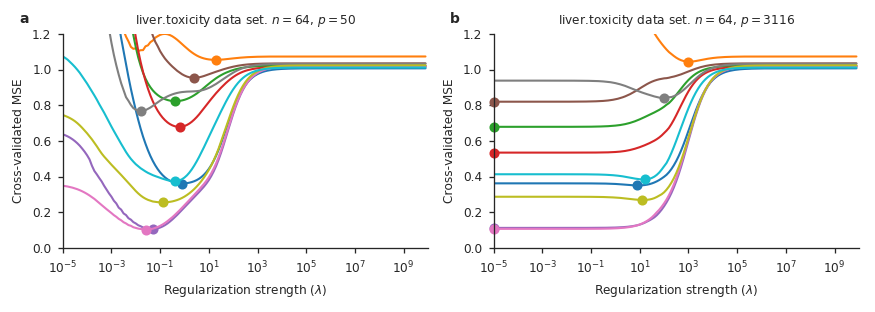

..........
..........
CPU times: user 54.3 s, sys: 528 ms, total: 54.8 s
Wall time: 27 s


In [8]:
%%time

# The same but using 50 predictors with the highest variance instead of 50 random predictors

X = np.loadtxt('livertoxicity-gene.txt')

X = X[:, np.argsort(np.std(X,axis=0))[::-1]]
X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)

makefigure1(X,Y)

<IPython.core.display.Javascript object>


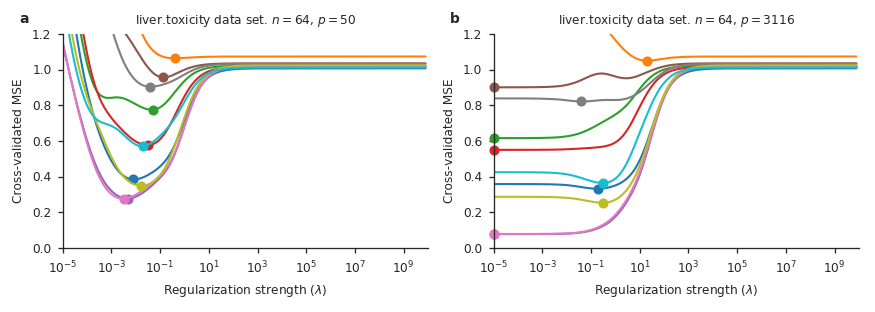

..........
..........
CPU times: user 54.4 s, sys: 468 ms, total: 54.9 s
Wall time: 22.1 s


In [9]:
%%time

# The same but without standardizing the predictors

X = np.loadtxt('livertoxicity-gene.txt')

np.random.seed(42)
X = X[:, np.random.permutation(X.shape[1])]
X = X - np.mean(X, axis=0)

makefigure1(X,Y)

## Toy model

In [16]:
def toymodelmse(n=64, ps=np.array([50]), rho=0.1, snr=10, nrep=100, 
                lambdau=np.array([1,2,3]), seed=42, verbose=2):
        
    np.random.seed(seed)
    expected_mse = np.zeros((ps.size, lambdau.size))
        
    for pnum, p in enumerate(ps):
    
        # generate the data
        sigma = np.ones((p,p)) * rho
        for d in range(p):
            sigma[d,d]=1
        cholesky_sigma = np.linalg.cholesky(sigma).T
        w = np.ones((p,1)) / np.sqrt((1+(p-1)*rho)*p) * np.sqrt(snr)
                
        mse = np.zeros((nrep, lambdau.size))
        for r in range(nrep):
            if verbose==2:
                print('.', end='')
            
            # generate training data
            Xtrain = np.random.randn(n,p) @ cholesky_sigma
            ytrain = Xtrain @ w + np.random.randn(n,1)
        
            # SVD of the training data to quickly solve ridge regression later
            [U,s,V] = np.linalg.svd(Xtrain, full_matrices = False)
            V = V.T
            
            # ridge estimators with various lambdas
            for i,l in enumerate(lambdau):
                beta = V @ np.diag(s/(s**2 + l)) @ U.T @ ytrain
                mse[r, i] = ((beta-w).T @ sigma @ (beta-w) + 1) / (w.T @ sigma @ w + 1)

        if verbose==2:
            print('')
        if verbose==1:
            print('.', end='')
    
        expected_mse[pnum, :] = np.mean(mse, axis=0)
    
    if verbose==1:
        print('')
    
    return expected_mse

In [17]:
%%time

nrep = 100

ps = np.array([50, 75, 150, 1000])
lambdau = np.array(10.0**np.arange(-5,10,.1))
%time expected_mse = toymodelmse(ps=ps, lambdau=lambdau, nrep=nrep)
print('')

ps_scan = np.concatenate((np.arange(10,100), np.arange(100,1001,10)))
lambdau_scan = np.array([0, -10])
%time expected_mse_scan = toymodelmse(ps=ps_scan, lambdau=lambdau_scan, nrep=nrep, verbose=1)
print('')

p = np.array([1000])
lambdau_aroundzero = np.arange(-500,1000,10)
%time expected_mse_aroundzero = toymodelmse(ps=p, lambdau=lambdau_aroundzero, nrep=nrep)
print('')

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
CPU times: user 56 s, sys: 148 ms, total: 56.2 s
Wall time: 14.1 s

.....................................................................................................................................................................................
CPU times: user 2min 31s, sys: 1.11 s, total: 2min 32s
Wall time: 38.2 s

....................................................................................................
CPU times: user 45.3 s, sys: 108 ms, total: 45.4 s
Wall time: 11.4 s

CPU times: user 4min 12s, sys: 1.36 s, total: 4min 14s
Wall time: 1min 3s


In [18]:
print('Optimal lambda:', lambdau_aroundzero[np.argmin(expected_mse_aroundzero[0,:])])

Optimal lambda: -110


<IPython.core.display.Javascript object>


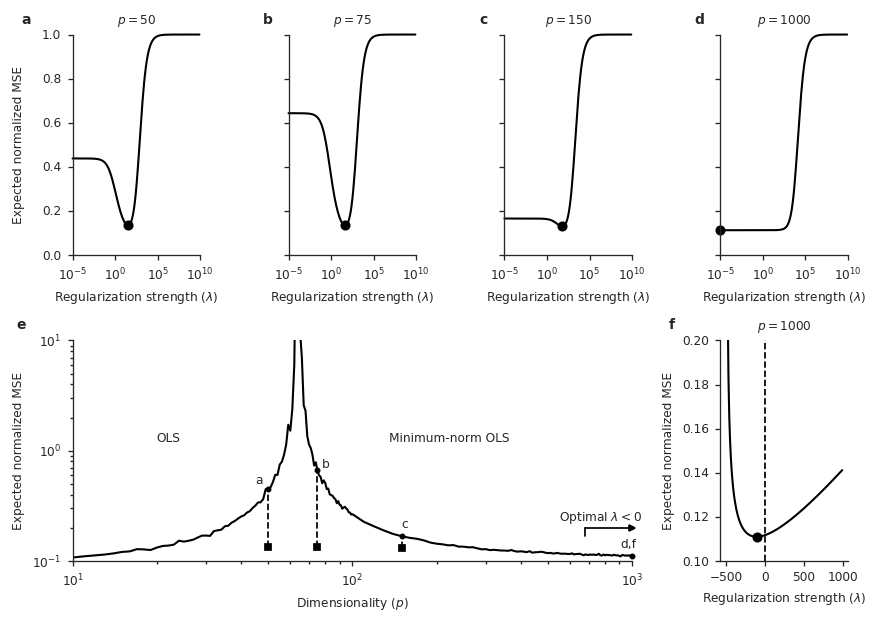

In [19]:
plt.figure(figsize=(7, 5))
grid = plt.GridSpec(2, 4)


################### panels a-d #######################

for i, p in enumerate(ps):
    plt.subplot(grid[i])
    plt.plot(lambdau, expected_mse[i,:], color='k', clip_on=False)
    plt.plot(lambdau[np.argmin(expected_mse[i,:])], np.min(expected_mse[i,:]), 'o', color='k', clip_on=False)
    plt.xscale('log')
    
    plt.title('$p=' + str(p) + '$')
    if i==0:
        plt.ylabel('Expected normalized MSE')
    else:
        plt.gca().axes.yaxis.set_ticklabels([])
    plt.xlabel('Regularization strength ($\lambda$)')
    plt.ylim([0, 1])
    plt.xlim([10**-5,10**10])
    plt.xticks([10**-5, 10**0, 10**5, 10**10])


#################### panel e ##########################

plt.subplot(grid[4:7])
plt.plot(ps_scan, expected_mse_scan[:,0], 'k')

plt.xlabel('Dimensionality ($p$)')
plt.ylabel('Expected normalized MSE')
plt.yscale('log')
plt.xscale('log')
plt.ylim([0.1, 10])
plt.xlim([10,1000])

for i,p in enumerate(ps[:-1]):
    plt.plot([p,p], [np.min(expected_mse[i,:]), expected_mse_scan[ps_scan==p,0]], 'k--', linewidth=1)
    plt.plot(p, np.min(expected_mse[i,:]), 'ks', markersize=3)
    plt.plot(p, expected_mse_scan[ps_scan==p,0], 'k.')
plt.plot(1000, expected_mse_scan[ps_scan==1000,0], 'k.', clip_on=False)
    
plt.text(20,1.2, 'OLS', fontsize=7)
plt.text(135,1.2, 'Minimum-norm OLS', fontsize=7)
plt.text(45,.5, 'a', fontsize=7)
plt.text(78,.7, 'b', fontsize=7)
plt.text(150,.2, 'c', fontsize=7)
plt.text(910,.13, 'd,f', fontsize=7)
    
beg = ps_scan[np.where(expected_mse_scan[:,1] > expected_mse_scan[:,0])[0][-1]+1]
plt.plot([beg, 1000], [.2,.2], 'k', linewidth=1, clip_on=False)
plt.plot(1000, .2, 'k>', markersize=3, clip_on=False)
plt.plot([beg, beg], [.17,.2], 'k', linewidth=1)
plt.text(550, .23, 'Optimal $\lambda<0$', fontsize=7);


##################### panel f ##########################

plt.subplot(grid[-1])

plt.plot(lambdau_aroundzero, expected_mse_aroundzero[0,:], color='k')
plt.plot(lambdau_aroundzero[np.argmin(expected_mse_aroundzero[0,:])], 
         np.min(expected_mse_aroundzero[0,:]), 'o', color='k', clip_on=False)
    
plt.title('$p=1000$')
plt.ylabel('Expected normalized MSE')
plt.xlabel('Regularization strength ($\lambda$)')
plt.ylim([.1, .2])
plt.plot([0,0], [.1, .2], 'k--', linewidth=1)
plt.xticks([-500,0,500,1000])
# plt.xlim([-500,1000])

########################################################

sns.despine()
plt.tight_layout()

plt.text(-.4, 1.05, 'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=8, fontweight='bold')
plt.text(-.2, 1.05, 'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=8, fontweight='bold')
plt.text(-.2, 1.05, 'c', transform = plt.gcf().get_axes()[2].transAxes, fontsize=8, fontweight='bold')
plt.text(-.2, 1.05, 'd', transform = plt.gcf().get_axes()[3].transAxes, fontsize=8, fontweight='bold')
plt.text(-.1, 1.05, 'e', transform = plt.gcf().get_axes()[4].transAxes, fontsize=8, fontweight='bold')
plt.text(-.4, 1.05, 'f', transform = plt.gcf().get_axes()[5].transAxes, fontsize=8, fontweight='bold')

plt.gcf().align_ylabels()
plt.savefig('figures/toy.pdf')

## Augmenting the toy model with random predictors

In [48]:
%%time

ntest = 10000
p = 50
n = 64
rho = 0.1
snr = 10
nrep = 100

fakevar = np.array([np.nan, 1, .1])     # NaN means adaptive variance = lambda/p
fakenum = np.arange(0,601,10)
lambdau = np.array(10.0**np.arange(-5,10,.1))
np.random.seed(42)

# common test set
sigma = np.ones((p,p)) * rho
for d in range(p):
    sigma[d,d]=1
cholesky_sigma = np.linalg.cholesky(sigma).T
w = np.ones((p,1)) / np.sqrt((1+(p-1)*rho)*p) * np.sqrt(snr)

# generating training sets here so that all subplots could use the same ones
trainingSets = []
for r in range(nrep):
    Xtrain = np.random.randn(n,p) @ cholesky_sigma
    ytrain = Xtrain @ w + np.random.randn(n,1)
    trainingSets.append((Xtrain, ytrain))
    
# The first subplot is ridge
mse_ridge = np.zeros((nrep, lambdau.size))
for r in range(nrep):
    print('.', end='')
    (Xtrain, ytrain) = trainingSets[r]
    [U,s,V] = np.linalg.svd(Xtrain, full_matrices = False)
    V = V.T
    
    for i,l in enumerate(lambdau):
        beta = V @ np.diag(s/(s**2 + l)) @ U.T @ ytrain
        mse_ridge[r, i] = ((beta-w).T @ sigma @ (beta-w) + 1) / (w.T @ sigma @ w + 1)
print('')

mse_ridge = np.mean(mse_ridge, axis=0)
ridgebest = np.min(mse_ridge)
bestlambda = lambdau[np.argmin(mse_ridge)]
print('Optimal lambda:', bestlambda)

# The following subplots are adding random predictors
mse_fake = []
mse_fake_nontrunc = []

for sigma2 in fakevar:

    mse = np.zeros((nrep, fakenum.size))
    mse_nontrunc = np.zeros((nrep, fakenum.size))

    for r in range(nrep):
        print('.', end='')
        (Xtrain, ytrain) = trainingSets[r]
        
        for i,pfake in enumerate(fakenum):
            if np.isnan(sigma2):
                fakestd = np.sqrt(bestlambda / np.maximum(pfake,1))  # avoiding division by 0
            else:
                fakestd = np.sqrt(sigma2)
                
            Xfake = np.random.randn(n, pfake) * fakestd
            [U,s,V] = np.linalg.svd(np.concatenate((Xtrain,Xfake), axis=1), full_matrices = False)
            V = V.T   
            beta = V @ np.diag(s**(-1)) @ U.T @ ytrain
            beta_trunc = beta[:p]
            
            mse[r, i] = ((beta_trunc-w).T @ sigma @ (beta_trunc-w) + 1) / (w.T @ sigma @ w + 1)
            
            w_extended = np.concatenate((w, np.zeros((pfake,1))))
            from scipy.linalg import block_diag
            sigma_extended = block_diag(sigma, np.eye(pfake) * fakestd**2)
            mse_nontrunc[r, i] = ((beta-w_extended).T @ sigma_extended @ (beta-w_extended) 
                                  + 1) / (w.T @ sigma @ w + 1)
    print('')
    
    mse = np.mean(mse, axis=0)
    mse_nontrunc = np.mean(mse_nontrunc, axis=0)
    
    mse_fake.append(mse)
    mse_fake_nontrunc.append(mse_nontrunc)

....................................................................................................
Optimal lambda: 31.622776601682112
....................................................................................................
....................................................................................................
....................................................................................................
CPU times: user 2min 42s, sys: 1.4 s, total: 2min 43s
Wall time: 41 s


<IPython.core.display.Javascript object>


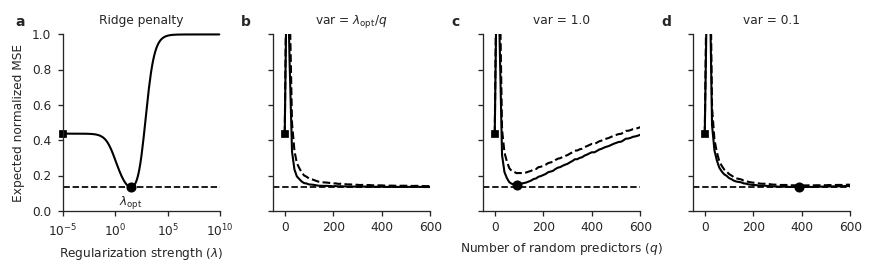

In [49]:
plt.figure(figsize=(7, 2.2))

plt.subplot(1, fakevar.size+1, 1)
plt.plot(lambdau, mse_ridge, color='k', clip_on=False)
# plt.plot(bestlambda * np.array([1,1]), [0,ridgebest], 'k--', linewidth=1)
plt.text(bestlambda, ridgebest-.1, '$\lambda_\mathrm{opt}$', ha='center', fontsize=7)
plt.plot(bestlambda, ridgebest, 'o', color='k')
plt.plot(lambdau[0], mse[0], 's', markersize=3, color='k', clip_on=False)
plt.plot(plt.xlim(), [ridgebest,ridgebest], 'k--', linewidth=1)
plt.title('Ridge penalty')
plt.ylabel('Expected normalized MSE')
plt.xlabel('Regularization strength ($\lambda$)')
plt.xscale('log')
plt.ylim([0, 1])
plt.xlim([10**-5,10**10])
plt.xticks([10**-5, 10**0, 10**5, 10**10])
    
for i in range(fakevar.size):
    plt.subplot(1, fakevar.size+1, i+2)
    plt.ylim([0, 1])
    plt.xlim([-50, fakenum[-1]])
    plt.xticks([0,200,400,600])
    
    plt.plot(fakenum, mse_fake_nontrunc[i], '--', color='k')#, dashes=(5, 5))
    plt.plot(plt.xlim(), [ridgebest,ridgebest], 'k--', linewidth=1)
    plt.plot(fakenum, mse_fake[i], color='k')
    if ~np.isnan(fakevar[i]):
        plt.plot(fakenum[np.argmin(mse_fake[i])], np.min(mse_fake[i]), 'o', color='k')
    plt.plot(0, mse_fake[i][0], 's', color='k', markersize=3)
    if np.isnan(fakevar[i]):
        plt.title('var = $\lambda_\mathrm{opt}/q$')
    else:
        plt.title('var = {}'.format(fakevar[i]))
    plt.gca().axes.yaxis.set_ticklabels([])
    
    if i==1:
        plt.xlabel('Number of random predictors ($q$)')

sns.despine()
plt.tight_layout()

plt.text(-.3, 1.05, 'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=8, fontweight='bold')
plt.text(-.2, 1.05, 'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=8, fontweight='bold')
plt.text(-.2, 1.05, 'c', transform = plt.gcf().get_axes()[2].transAxes, fontsize=8, fontweight='bold')
plt.text(-.2, 1.05, 'd', transform = plt.gcf().get_axes()[3].transAxes, fontsize=8, fontweight='bold')

plt.savefig('figures/fakepredictors.pdf')